# Importing Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Dependent Variables 
### Salmon viability

In [98]:
# import the salmon survival rate data from Perry et al (2021)
Sal_viab = pd.read_excel('../Ian-Paper1/Perry et al 2021 PLoS ONE S2_Table.xlsx', sheet_name=5)

Sal_viab = Sal_viab.rename(columns={'Ocean Entry Year':'Year'}).drop(columns=['Year'])

# take logit of Sal_viab values, because these are proportions in (0,1)
# this is done in the Perry et al paper too
from scipy.special import logit, expit

Sal_viab_logit = logit(Sal_viab).interpolate()

## Independent Variables
### BC and WA regional populations and population trends, Port of Vancouver tonnage cargo, NPGO climate index 

In [99]:
# import the population data for BC Regional Districts
BC_pop = pd.read_csv('Population/BCPop1990.csv')#, index_col=0) # only need index_col=0 to make years the indices
BC_pop = BC_pop.rename(columns={'Unnamed: 0':'Year'}).drop_duplicates() # there's a duplicate row at 2011!

# pre-2001 BC population numbers are only for every five years
# make an empty table for these years, to be interpolated
missing_yrs = np.setdiff1d([i for i in range(1990,2001)],[1991,1996])
missing_yrs_vals = np.empty((29,9,))*np.nan
missing_data = np.vstack((missing_yrs,missing_yrs_vals)).transpose()
BC_missing = pd.DataFrame(missing_data)
BC_missing.columns = BC_pop.columns
BC_pop = pd.concat([BC_missing,BC_pop]).sort_values(by='Year')

# fill in the missing years with some linearly interpolated values where possible
# and where this doesn't fill in a value, just repeat the closest value
BC_pop = BC_pop.interpolate().bfill() 
# fix the indices obtained from concatenating
BC_pop = BC_pop.reset_index().drop(columns=['index'])


# import the population data for BC Regional Districts and WA Counties
WA_pop = pd.read_csv('Population/WAPop1990.csv')# index_col=0)
WA_pop = WA_pop.rename(columns={'Unnamed: 0':'Year'})

In [100]:
# BC Group 1 average
BC_1 = BC_pop.iloc[:,[3,7,9,10,12,14,18,20,25,28,29]]
BC_1_avg = pd.DataFrame(BC_1.mean(axis=1), columns=['BC Gp1 Avg'])
# BC Group 2 average
BC_2 = BC_pop.iloc[:,[2,5,15,17,19]]
BC_2_avg = pd.DataFrame(BC_2.mean(axis=1), columns=['BC Gp2 Avg'])
# BC Group 3 average
BC_3 = BC_pop.iloc[:,[6,8,11,13,16,22]]
BC_3_avg = pd.DataFrame(BC_3.mean(axis=1),columns=['BC Gp3 Avg'])
# BC Group 4 average
BC_4 = BC_pop.iloc[:,[1,4,24,27]]
BC_4_avg = pd.DataFrame(BC_4.mean(axis=1),columns=['BC Gp4 Avg'])
# BC Group 5 average
BC_5 = BC_pop.iloc[:,[21,23,26]]
BC_5_avg = pd.DataFrame(BC_5.mean(axis=1),columns=['BC Gp5 Avg'])

# WA Group 1 average
WA_1 = WA_pop.iloc[:,[1,3,5,6,8,9,13,16,19,20,21,23,27,29,31,32,34,36,37,39]]
WA_1_avg = pd.DataFrame(WA_1.mean(axis=1),columns=['WA Gp1 Avg'])
# WA Group 2 average
WA_2 = WA_pop.iloc[:,[2,4,18,22,24,25,26,28,30,33,35]]
WA_2_avg = pd.DataFrame(WA_2.mean(axis=1),columns=['WA Gp2 Avg'])
# WA Group 3 average
WA_3 = WA_pop.iloc[:,[11,14,15,17,38]]
WA_3_avg = pd.DataFrame(WA_3.mean(axis=1),columns=['WA Gp3 Avg'])
# WA Group 4 average
WA_4 = WA_pop.iloc[:,[7,10,12]]
WA_4_avg = pd.DataFrame(WA_4.mean(axis=1),columns=['WA Gp4 Avg'])

In [101]:
# data on total tonnage of cargo through Port of Vancouver
# years 2008-2023 are given in the Port Metro Vancouver Statistics Overviews at https://www.portvancouver.com/about-us/statistics/
# years 1994-1998 are given in The Institutional Position of Seaports An International Comparison by Henrik Stevens, Chapter 7
PortofVan = pd.DataFrame({'Year':[1994,1995,1996,1997,1998]+[i for i in range(2008,2023)],  
                          'Tonnage':[67600000,71500000,72000000,73500000,71900000]+[114561990,101887824,118378885, 
                                122499631,123876885,135009878, 
                                139638157,138082585,135538055, 
                                142067550,147090934,144225630, 
                                145450722,146473626,141416326]})

missing_yrs_port = pd.DataFrame({'Year':[1990,1991,1992,1993,1999,2000,2001,2002,2003,2004,2005,2006,2007],
                               'Tonnage':[np.nan for _ in range(0,13)]})

# linearly interpolate the port traffic data
PortofVanExt = pd.concat([PortofVan,missing_yrs_port]).sort_values(by=['Year']).interpolate(method='linear', fill_value='extrapolate', limit_direction='both')
PortofVanExt = PortofVanExt.reset_index(drop=True).drop(columns=['Year'])

In [102]:
# import a climatological index
NPGO_monthly = pd.read_csv('NPGOMonthlyAvg copy.txt')

# get the yearly NPGO averages and clean it up
NPGO_yearly = NPGO_monthly.groupby('Year').mean()
NPGO_yearly = NPGO_yearly.drop(columns=['Month']).reset_index()
NPGO = NPGO_yearly.loc[(NPGO_yearly['Year']>=1990) & (NPGO_yearly['Year']<2023)]
NPGO = NPGO.reset_index().drop(columns=['index','Year'])

In [103]:
# making our train/test split
test_size = 5

# salmon data is for 1990 to 2017
Sal_viab_train = Sal_viab_logit.iloc[:-test_size]
Sal_viab_test = Sal_viab_logit.iloc[-test_size:-1]

# other data is for 1990 to 2022
BC_1_train = BC_1_avg.iloc[:-test_size-4]
BC_1_test = BC_1_avg.iloc[-test_size-4:-5]
BC_2_train = BC_2_avg.iloc[:-test_size-4]
BC_2_test = BC_2_avg.iloc[-test_size-4:-5]
BC_3_train = BC_3_avg.iloc[:-test_size-4]
BC_3_test = BC_3_avg.iloc[-test_size-4:-5]
BC_4_train = BC_4_avg.iloc[:-test_size-4]
BC_4_test = BC_4_avg.iloc[-test_size-4:-5]
BC_5_train = BC_5_avg.iloc[:-test_size-4]
BC_5_test = BC_5_avg.iloc[-test_size-4:-5]

WA_1_train = WA_1_avg.iloc[:-test_size-4]
WA_1_test = WA_1_avg.iloc[-test_size-4:-5]
WA_2_train = WA_2_avg.iloc[:-test_size-4]
WA_2_test = WA_2_avg.iloc[-test_size-4:-5]
WA_3_train = WA_3_avg.iloc[:-test_size-4]
WA_3_test = WA_3_avg.iloc[-test_size-4:-5]
WA_4_train = WA_4_avg.iloc[:-test_size-4]
WA_4_test = WA_4_avg.iloc[-test_size-4:-5]

Port_of_Van_train = PortofVanExt.iloc[:-test_size-4]
Port_of_Van_test = PortofVanExt.iloc[-test_size-4:-5]

NPGO_train = NPGO.iloc[:-test_size-4]
NPGO_test = NPGO.iloc[-test_size-4:-5]

In [109]:
big_table_train = pd.concat([Port_of_Van_train,
                             NPGO_train,
                             BC_1_train,
                             BC_2_train,
                             BC_3_train,
                             BC_4_train,
                             BC_5_train,
                             WA_1_train,
                             WA_2_train,
                             WA_3_train,
                             WA_4_train], axis=1)

big_table_test = pd.concat([Port_of_Van_test,
                             NPGO_test,
                             BC_1_test,
                             BC_2_test,
                             BC_3_test,
                             BC_4_test,
                             BC_5_test,
                             WA_1_test,
                             WA_2_test,
                             WA_3_test,
                             WA_4_test], axis=1)

In [110]:
big_table_test                         

,Tonnage,NPGO index,BC Gp1 Avg,BC Gp2 Avg,BC Gp3 Avg,BC Gp4 Avg,BC Gp5 Avg,WA Gp1 Avg,WA Gp2 Avg,WA Gp3 Avg,WA Gp4 Avg
24,139638157.0,-0.196440,361689.090909,22557.4,63880.166667,40074.50,24052.333333,208423.10,46853.727273,461539.4,4553.000000
25,138082585.0,-1.380775,367426.272727,22449.0,64772.333333,40345.00,24146.666667,211130.40,47254.454545,470114.4,4547.000000
26,135538055.0,-0.160382,374142.636364,22466.0,65872.666667,40939.25,24119.333333,214359.40,47812.636364,482103.4,4525.000000
27,142067550.0,-0.859153,379927.000000,22498.4,66665.833333,41353.50,24095.333333,217803.15,48140.272727,488988.4,4508.333333


# Modelling

In [106]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

In [150]:
pipe1 = Pipeline([
    ('scaling', StandardScaler()),
    ('linreg', LinearRegression(copy_X=True))
])

pipe2 = Pipeline([
    ('scaling', StandardScaler()),
    ('linreg', LinearRegression(copy_X=True))
])

pipe3 = Pipeline([
    ('scaling', StandardScaler()),
    ('linreg', LinearRegression(copy_X=True))
])

pipe4 = Pipeline([
    ('scaling', StandardScaler()),
    ('linreg', LinearRegression(copy_X=True))
])

In [151]:
fish_name_1 = Sal_viab.columns[0]
fish_name_2 = Sal_viab.columns[1]
fish_name_3 = Sal_viab.columns[2]
fish_name_4 = Sal_viab.columns[3]

pipe1.fit(big_table_train, Sal_viab_train[fish_name_1])
pipe2.fit(big_table_train, Sal_viab_train[fish_name_2])
pipe3.fit(big_table_train, Sal_viab_train[fish_name_3])
pipe4.fit(big_table_train, Sal_viab_train[fish_name_4])

Pipeline(steps=[('scaling', StandardScaler()), ('linreg', LinearRegression())])

In [152]:
predicted1 = pipe1.predict(big_table_test)
predicted2 = pipe2.predict(big_table_test)
predicted3 = pipe3.predict(big_table_test)
predicted4 = pipe4.predict(big_table_test)

In [ ]:
ax4.plot(time_sal,Sal_viab_nrm.iloc[:,1],marker = "o",label = 'Cowichan Chinook')
ax4.plot(time_sal,Sal_viab_nrm.iloc[:,2],marker = "o",label = 'Harrison Chinook')
ax4.plot(time_sal,Sal_viab_nrm.iloc[:,3],marker = "o",label = 'Puntledge Chinook')
ax4.plot(time_sal,Sal_viab_nrm.iloc[:,4],marker = "o",label = 'Big Qualicum Coho')


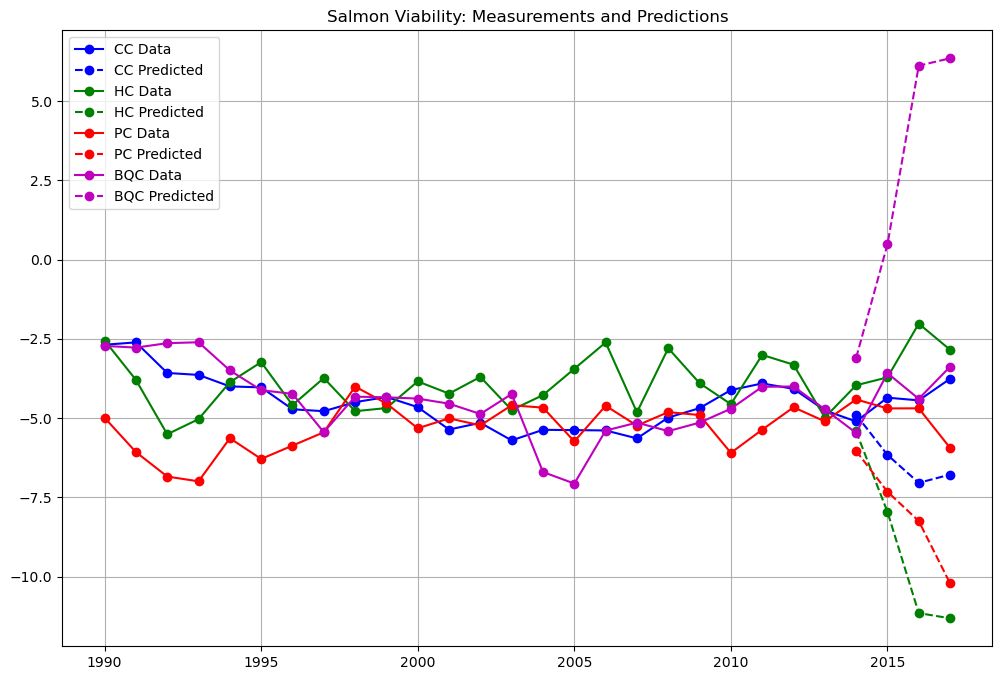

In [153]:
all_yrs = range(1990,2018)
train_yrs = range(1990,2019-test_size)
test_yrs = range(2019-test_size,2018)

plt.figure(figsize = (12,8))

#Plotting BC Regional District population vs Year
plt.title("Salmon Viability: Measurements and Predictions")

plt.plot(all_yrs, Sal_viab_logit[fish_name_1].iloc[:-1],marker = "o",label = 'CC Data',c='b')
plt.plot(test_yrs,predicted1,marker = "o",label = 'CC Predicted',c='b',ls='--')

plt.plot(all_yrs, Sal_viab_logit[fish_name_2].iloc[:-1],marker = "o",label = 'HC Data',c='g')
plt.plot(test_yrs,predicted2,marker = "o",label = 'HC Predicted',c='g',ls='--')

plt.plot(all_yrs, Sal_viab_logit[fish_name_3].iloc[:-1],marker = "o",label = 'PC Data',c='r')
plt.plot(test_yrs,predicted3,marker = "o",label = 'PC Predicted',c='r',ls='--')

plt.plot(all_yrs, Sal_viab_logit[fish_name_4].iloc[:-1],marker = "o",label = 'BQC Data',c='m')
plt.plot(test_yrs,predicted4,marker = "o",label = 'BQC Predicted',c='m',ls='--')


plt.legend()
plt.grid()

plt.show()